In [66]:
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import transforms
import torch.nn.functional as F
from torch import nn, optim 

from PIL import Image
import glob, re

import matplotlib.pyplot as plt

%matplotlib inline

In [47]:
class DogCat(Dataset):
    def __init__(self, path, transform):
        self.img_paths = glob.glob(path)
        self.cls = {'cat':0, 'dog':1}
        self.transforms = transform
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, i):
        img_name = self.img_paths[i]
        label = re.search(r'.*\\(.*)\.\d+', img_name).group(1)
        img = Image.open(img_name)
        img = self.transforms(img)
        return img, self.cls[label]

In [51]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(), 
                                transforms.Resize((62,62)),
                                transforms.RandomCrop((32,32), padding=4),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = DogCat('D:\Dog-data\dog-training\*.tif', transform=transform)  # 20000
test_data = DogCat('D:\Dog-data\dog-test\*.tif', transform=transform)  # 4000

train_sampler = sampler.SubsetRandomSampler(range(18000))
val_sampler = sampler.SubsetRandomSampler(range(18000, 20000))

train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=100)
val_loader = DataLoader(train_data, sampler=val_sampler, batch_size=2000)
test_loader = DataLoader(test_data, batch_size=4000)

In [70]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(  # 3 * 32 * 32 -> 32 * 16 * 16
            nn.Conv2d(3, 32, 5, 1, 2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2)
            )
        self.conv2 = nn.Sequential(  # 32 * 16 * 16 -> 64 * 8 * 8
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
        )
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 4096)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [101]:
def train(model, train_loader, criterion, optimizer, train_size, epochs=10):
    losses, val_losses = [], []
    acces, val_acces = [], []
    
    for epoch in range(epochs):
        loss_sum = 0
        correct = 0
        for img, label in train_loader:
            label = label.float()
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                out = model(img).squeeze()
                loss = criterion(out, label)
                loss.backward()
                optimizer.step()
            loss_sum += loss
            
            correct += ((label - F.sigmoid(out)).abs() <= 0.5).sum().item()
        
        val_loss, val_acc = predict(val_loader, model, criterion)
        epoch_loss, epoch_acc = loss_sum / len(train_loader), correct / train_size
        
        val_losses.append(val_loss)
        val_acces.append(val_acc)
        losses.append(epoch_loss)
        acces.append(epoch_acc)
        
        if (epoch + 1) % 2 == 0:
            print("Epoch {} finished, current loss is {}, \
                  validation accuracy is {}".format(epoch + 1, epoch_loss, val_acc))
            torch.save(model, '{}epoch_result'.format(epoch + 1))
        
    return losses, acces, val_losses, val_acces

def predict(dataset, model, criterion):
    single_batch = next(iter(dataset))
    img, label = single_batch[0], single_batch[1].float()
    with torch.no_grad():
        out = model(img).squeeze()
        loss = criterion(out, label)
        acc = ((label - F.sigmoid(out)).abs() <= 0.5).sum().item()
    
    return loss.item(), acc / img.size(0)

In [98]:
%%time
#model = ConvNet()
model = torch.load('9epoch_result')
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), 1e-3, (0.9, 0.999))

loss, acc, val_losses, val_acces = train(model, train_loader, criterion, optimizer, train_size=20000)

Epoch 2 finished, current loss is 0.5197381377220154, \                  validation accuracy is 0.5675


D:\programming_tools\Anaconda3\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 4 finished, current loss is 0.5077508091926575, \                  validation accuracy is 0.5075
Epoch 6 finished, current loss is 0.49676141142845154, \                  validation accuracy is 0.5195
Epoch 8 finished, current loss is 0.49117371439933777, \                  validation accuracy is 0.579
Epoch 10 finished, current loss is 0.4805852174758911, \                  validation accuracy is 0.5625
Wall time: 23min 55s


In [99]:
%%time

_, pred_acc = predict(test_loader, model, criterion)
print(pred_acc)

0.7675
Wall time: 25.3 s


Text(0,0.5,'accuracy')

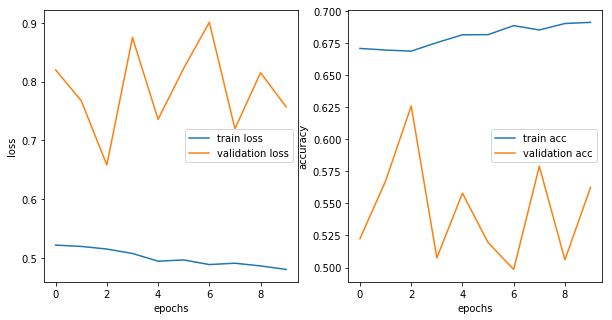

In [100]:
plt.figure(figsize=(10,5))
plt.subplot(121)
p1, = plt.plot(loss)
p3, = plt.plot(val_losses)
plt.legend([p1,p3], ['train loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

plt.subplot(122)
p2, = plt.plot(acc)
p4, = plt.plot(val_acces)
plt.legend([p2, p4], ['train acc', 'validation acc'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

In [110]:
import torchvision

transform = transforms.Compose([transforms.RandomHorizontalFlip(), 
                                transforms.RandomCrop((224,224)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = DogCat('D:\Dog-data\dog-training\*.tif', transform=transform)  # 20000
test_data = DogCat('D:\Dog-data\dog-test\*.tif', transform=transform)  # 4000

train_sampler = sampler.SubsetRandomSampler(range(18000))
val_sampler = sampler.SubsetRandomSampler(range(18000, 20000))

train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=100)
val_loader = DataLoader(train_data, sampler=val_sampler, batch_size=2000)
test_loader = DataLoader(test_data, batch_size=4000)

resnet = torchvision.models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

features = resnet.fc.in_features  # 512  
resnet.fc = nn.Linear(features, 1) 

In [ ]:
%%time
#model = ConvNet()
model = resnet
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.fc.parameters(), 1e-3, (0.9, 0.999))

loss, acc, val_losses, val_acces = train(model, train_loader, criterion, optimizer, train_size=20000)